In [1]:
import numpy as np
import pandas as pd
from tdc.multi_pred import DTI
from rdkit import Chem
import torch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import metrics
import sklearn as sk


In [2]:
# =============================================================================
# torch_data Loading
# =============================================================================
data = DTI(name = 'BindingDB_Kd')
bindingDB_data = data.get_data()[['Drug_ID','Drug']] 

bindingDB_data = bindingDB_data.drop_duplicates().reset_index(drop=True)


bindingDB_data['Drug_vector'] = ''

for ind, drug in enumerate(bindingDB_data['Drug']):
    mol = Chem.MolFromSmiles(drug)
    fp = Chem.RDKFingerprint(mol)
    intmap = map(int, fp.ToBitString())
    bindingDB_data['Drug_vector'][ind] = np.array(list(intmap))
    
torch_data = torch.tensor(list(bindingDB_data['Drug_vector']))

Found local copy...
Loading...
Done!


In [3]:
# =============================================================================
# Agglomerative
# =============================================================================

clusters={}
silhouette_avg={}
cluster_num_list = [i*10 for i in range(1,16)]

for n_cluster in cluster_num_list:
    clustering = AgglomerativeClustering(linkage='average', n_clusters=n_cluster)
    clustering.fit(torch_data)
    clusters[n_cluster] = clustering.labels_
    silhouette_avg[n_cluster] = silhouette_score(torch_data, clustering.labels_)
    
# =============================================================================
# Kmeans
# =============================================================================

clusters_kmeans={}
silhouette_avg_kmeans={}
cluster_num_list = [i*10 for i in range(1,16)]

for n_cluster in cluster_num_list:
    model = KMeans(n_clusters=n_cluster)
    model.fit(torch_data)
    clusters_kmeans[n_cluster] = model.labels_
    silhouette_avg_kmeans[n_cluster] = silhouette_score(torch_data, model.labels_)
    
    
# =============================================================================
# spectral
# =============================================================================

clusters_spectral={}
silhouette_avg_spectral={}
cluster_num_list = [i*10 for i in range(1,16)]
spectral_Data = torch_data
spectral_Data = sk.metrics.pairwise.pairwise_distances(spectral_Data, metric='euclidean')    # converts the distance matrix in above step to a similarity matrix
beta = 1.0
spectral_Data = np.exp(-beta * spectral_Data / spectral_Data.std())

for n_cluster in cluster_num_list:

    model = SpectralClustering(n_clusters=n_cluster, n_init=1, n_neighbors=5, eigen_tol=0.000001,
                                        n_jobs=6,random_state=46,eigen_solver='amg',affinity='precomputed')
    model.fit(spectral_Data)
    clusters_spectral[n_cluster] = model.labels_
    silhouette_avg_spectral[n_cluster] = silhouette_score(spectral_Data, model.labels_)

In [5]:
# =============================================================================
# Plots
# =============================================================================

n_clusters = 50

X = torch_data
y = clusters[n_clusters]

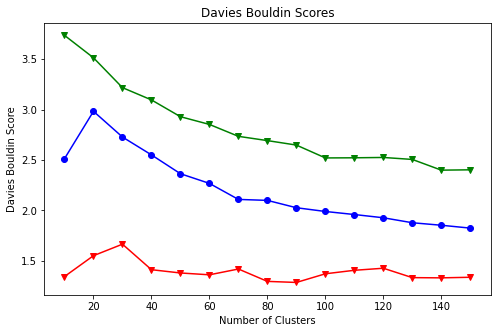

In [6]:
# =============================================================================
# Davies Bouldin
# =============================================================================

from sklearn.metrics import davies_bouldin_score

davies_bouldin_mapping_agg={}
davies_bouldin_mapping_kmeans={}
davies_bouldin_mapping_spectral={}

for n_cluster in cluster_num_list:
    davies_bouldin_mapping_spectral[n_cluster] = davies_bouldin_score(X, clusters_spectral[n_cluster])

for n_cluster in cluster_num_list:
    davies_bouldin_mapping_agg[n_cluster] = davies_bouldin_score(X, clusters[n_cluster])
    
for n_cluster in cluster_num_list:
    davies_bouldin_mapping_kmeans[n_cluster] = davies_bouldin_score(X, clusters_kmeans[n_cluster])

plt.figure(figsize=(8,5))
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('Davies Bouldin Scores')
plt.plot(cluster_num_list, list(davies_bouldin_mapping_agg.values()),'bo-')
plt.plot(cluster_num_list, list(davies_bouldin_mapping_kmeans.values()),'gv-')
plt.plot(cluster_num_list, list(davies_bouldin_mapping_spectral.values()),'rv-')
plt.show()

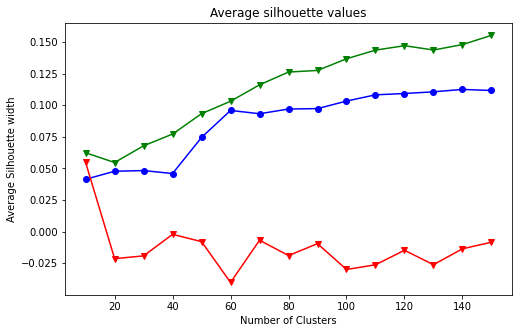

In [7]:
# =============================================================================
# silhouette
# =============================================================================

plt.figure(figsize=(8,5))
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette width')
plt.title('Average silhouette values')
plt.plot(cluster_num_list, list(silhouette_avg.values()),'bo-')
plt.plot(cluster_num_list, list(silhouette_avg_kmeans.values()),'gv-')
plt.plot(cluster_num_list, list(silhouette_avg_spectral.values()),'rv-')
plt.show()

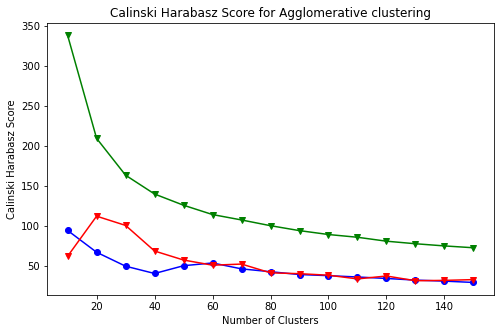

In [8]:
# =============================================================================
# Calinski Harabasz
# =============================================================================

calinski_harabasz_mapping={}

for n_cluster in cluster_num_list:
    calinski_harabasz_mapping[n_cluster] = metrics.calinski_harabasz_score(X, clusters[n_cluster])

calinski_harabasz_mapping_spectral={}

for n_cluster in cluster_num_list:
    calinski_harabasz_mapping_spectral[n_cluster] = metrics.calinski_harabasz_score(X, clusters_spectral[n_cluster])
    
calinski_harabasz_mapping_kmeans={}

for n_cluster in cluster_num_list:
    calinski_harabasz_mapping_kmeans[n_cluster] = metrics.calinski_harabasz_score(X, clusters_kmeans[n_cluster])

plt.figure(figsize=(8,5))
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('Calinski Harabasz Score for Agglomerative clustering')
plt.plot(cluster_num_list, list(calinski_harabasz_mapping.values()),'bo-')
plt.plot(cluster_num_list, list(calinski_harabasz_mapping_kmeans.values()),'gv-')
plt.plot(cluster_num_list, list(calinski_harabasz_mapping_spectral.values()),'rv-')
plt.show()

Text(0.5, 1.0, 'Cluster analysis')

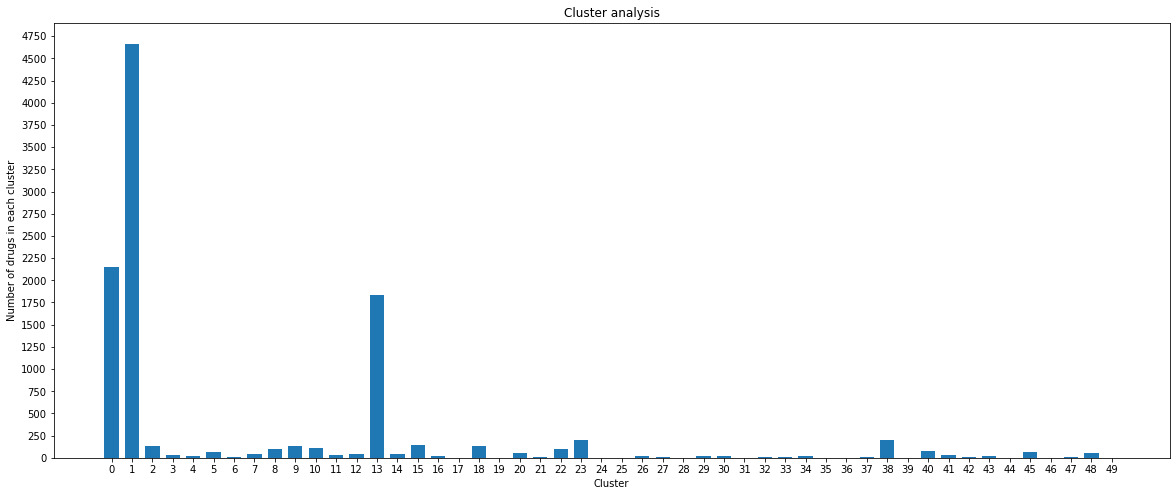

In [9]:
# =============================================================================
# cluster sizes
# =============================================================================


bindingDB_data['Cluster'] = clusters[n_clusters]
by_clusters = bindingDB_data.groupby(['Cluster'])

cluster_count = bindingDB_data.groupby(['Cluster'])['Drug'].count()
cluster_count_mapping = {k:v for k,v in enumerate(cluster_count)}

fig = plt.subplots(figsize=(20,8))

plt.bar(range(len(cluster_count_mapping)), cluster_count_mapping.values(), align='center', width=0.7)
plt.xlabel('Cluster')
plt.xticks(np.arange(n_clusters))
plt.yticks(np.arange(0, max(cluster_count_mapping.values()) + 100, step=250))
plt.ylabel('Number of drugs in each cluster')
plt.title('Cluster analysis')

Text(0.5, 1.0, 'Cluster analysis')

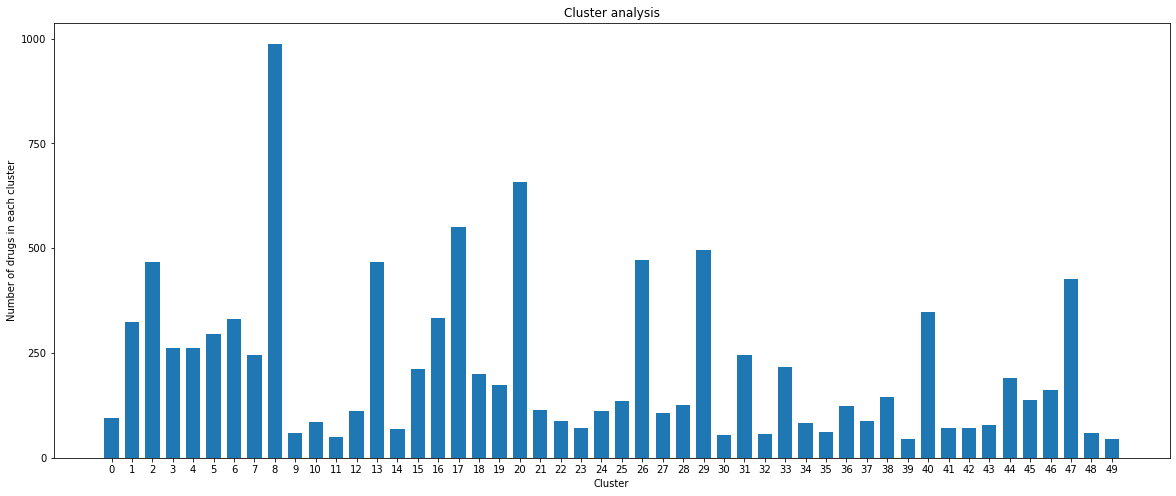

In [10]:
bindingDB_data['Cluster'] = clusters_kmeans[n_clusters]
kmeans_count = bindingDB_data.groupby(['Cluster'])['Drug'].count()
kmeans_count_mapping = {k:v for k,v in enumerate(kmeans_count)}

fig = plt.subplots(figsize=(20,8))

plt.bar(range(len(kmeans_count_mapping)), kmeans_count_mapping.values(), align='center', width=0.7)
plt.xlabel('Cluster')
plt.xticks(np.arange(n_clusters))
plt.yticks(np.arange(0, max(kmeans_count_mapping.values()) + 100, step=250))
plt.ylabel('Number of drugs in each cluster')
plt.title('Cluster analysis')

Text(0.5, 1.0, 'Cluster analysis')

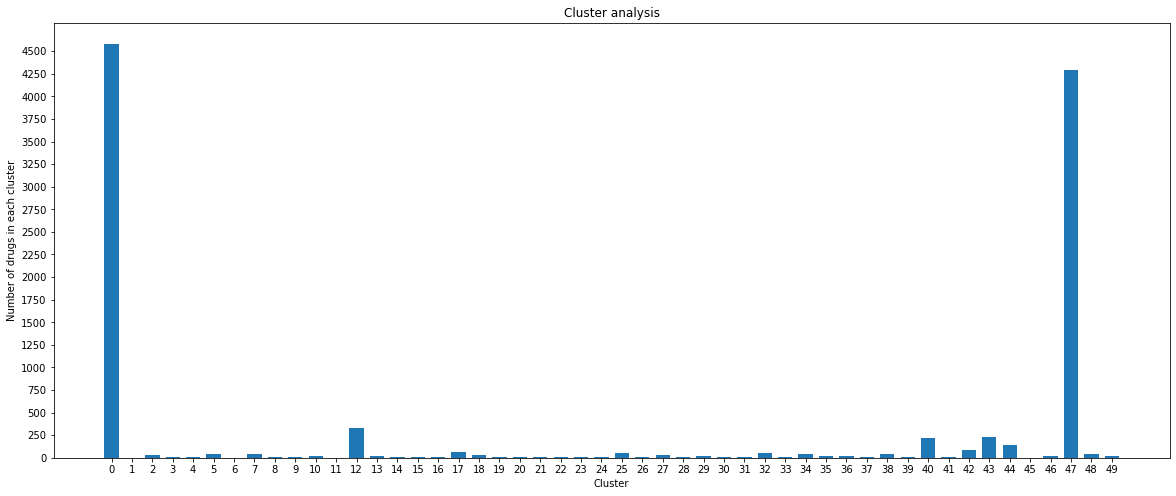

In [11]:
bindingDB_data['Cluster'] = clusters_spectral[n_clusters]
spectral_count = bindingDB_data.groupby(['Cluster'])['Drug'].count()
spectral_count_mapping = {k:v for k,v in enumerate(spectral_count)}

fig = plt.subplots(figsize=(20,8))

plt.bar(range(len(spectral_count_mapping)), spectral_count_mapping.values(), align='center', width=0.7)
plt.xlabel('Cluster')
plt.xticks(np.arange(n_clusters))
plt.yticks(np.arange(0, max(spectral_count_mapping.values()) + 100, step=250))
plt.ylabel('Number of drugs in each cluster')
plt.title('Cluster analysis')

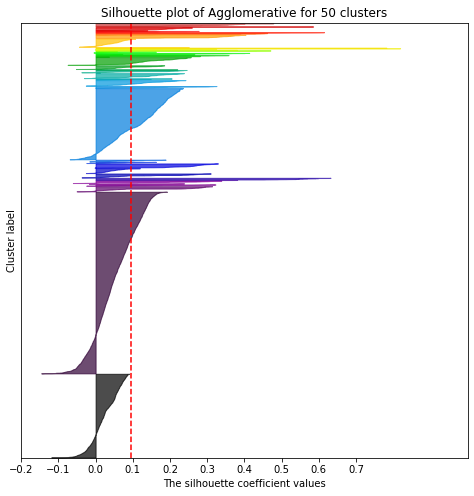

In [12]:
X = torch_data
y = clusters[n_clusters]
sample_silhouette_values = silhouette_samples(X, y)

fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
y_lower = 10

for i in range(n_clusters):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    #ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("Silhouette plot of Agglomerative for " + str(n_clusters) + ' clusters')
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg[60], color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7])

cluster_33_torch_data = bindingDB_data[bindingDB_data['Cluster'] == 33]

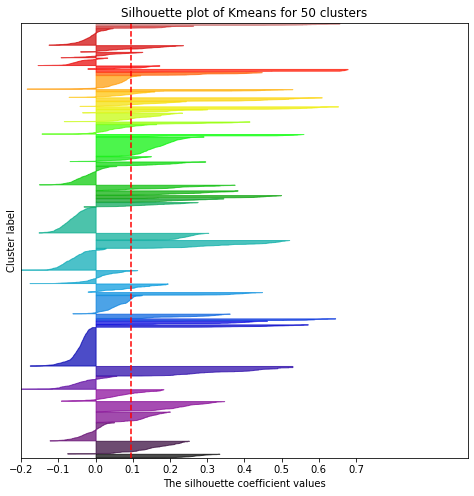

In [13]:
bindingDB_data['Cluster'] = clusters_kmeans[n_clusters]

X = torch_data
y = clusters_kmeans[n_clusters]
sample_silhouette_values = silhouette_samples(X, y)

fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
y_lower = 10

for i in range(n_clusters):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    #ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("Silhouette plot of Kmeans for " + str(n_clusters) + ' clusters')
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg[60], color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7])

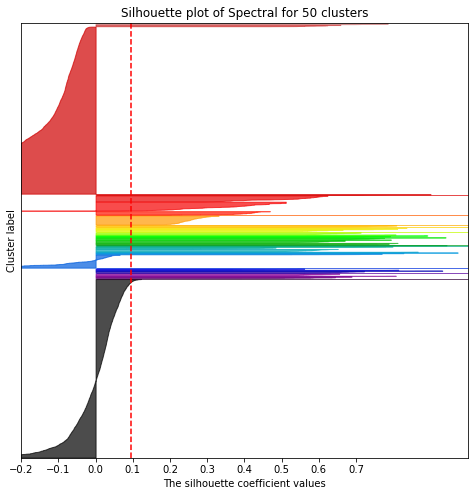

In [14]:

bindingDB_data['Cluster'] = clusters_spectral[n_clusters]

X = torch_data
y = clusters_spectral[n_clusters]
sample_silhouette_values = silhouette_samples(X, y)

fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
y_lower = 10

for i in range(n_clusters):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    #ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("Silhouette plot of Spectral for " + str(n_clusters) + ' clusters')
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg[60], color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7])